In [ ]:
import pandas as pd 
import numpy as np
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 2
import matplotlib
import matplotlib.pyplot as plt
import celltypist
from celltypist import models

In [2]:
def load_mf_sets(path):
    df_raw = pd.read_csv(path)
    df_T = df_raw.T
    genes = df_T.loc['Unnamed: 0']
    genes.name = 'genes'
    cells = df_T.index[1:]
    exp_data = df_T.loc[cells].astype('float')
    adata = ad.AnnData(X=exp_data)
    adata.obs_names = cells
    adata.var_names = genes
    return adata

In [4]:
# load the datasets
fp = '/Users/francescafoglino/Documents/COLLEGE/Senior/Fall 2024/ECBM 4060 Genomic Info/final_proj/gaydosik_2019_data_GSE128531/GSE128531_RAW/'   

mf2f = 'GSM3679033_Labeled_SC67_050517_SK_MF2_GRCh38raw.csv.gz'
mf5f = 'GSM3679034_Labeled_SC82_060617_SK_MF5_GRCh38raw.csv.gz'
mf6f = 'GSM3679035_SC157dataframe.csv.gz'
mf8f = 'GSM3679036_SC158dataframe.csv.gz'
mf12f = 'GSM3679037_SC205dataframe.csv.gz'
hc1f = 'GSM3679038_Labeled_SC50_011917_SK_NOR_GRCh38raw.csv.gz'
hc2f = 'GSM3679039_Labeled_SC68_051517_SK_NOR_GRCh38raw.csv.gz'
hc3f = 'GSM3679040_Labeled_SC124_080317_SK_NOR_GRCh38raw.csv.gz'
hc4f = 'GSM3679041_Labeled_SC125_080317_SK_NOR_GRCh38raw.csv.gz'

mf2p = load_mf_sets(fp+mf2f)
mf5p = load_mf_sets(fp+mf5f)
mf6p = load_mf_sets(fp+mf6f)
mf8p = load_mf_sets(fp+mf8f)
mf12p = load_mf_sets(fp+mf12f)
hc1p = load_mf_sets(fp+hc1f)
hc2p = load_mf_sets(fp+hc2f)
hc3p = load_mf_sets(fp+hc3f)
hc4p = load_mf_sets(fp+hc4f)

In [5]:
prefilt_dsets = [mf2p, mf5p, mf6p, mf8p, mf12p, hc1p, hc2p, hc3p, hc4p]

In [6]:
# qc metrics
for dset in prefilt_dsets:
    dset.var["mt"] = dset.var_names.str.startswith("MT-")
    dset.var["ribo"] = dset.var_names.str.startswith(("RPS", "RPL"))
    dset.var["hb"] = dset.var_names.str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(dset, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

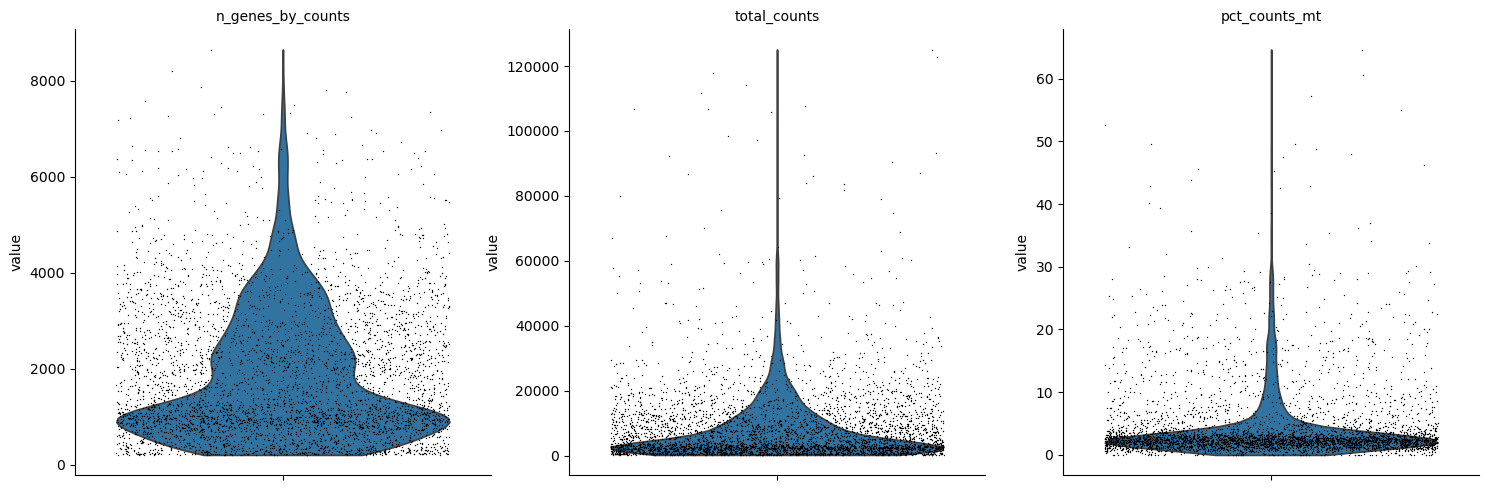

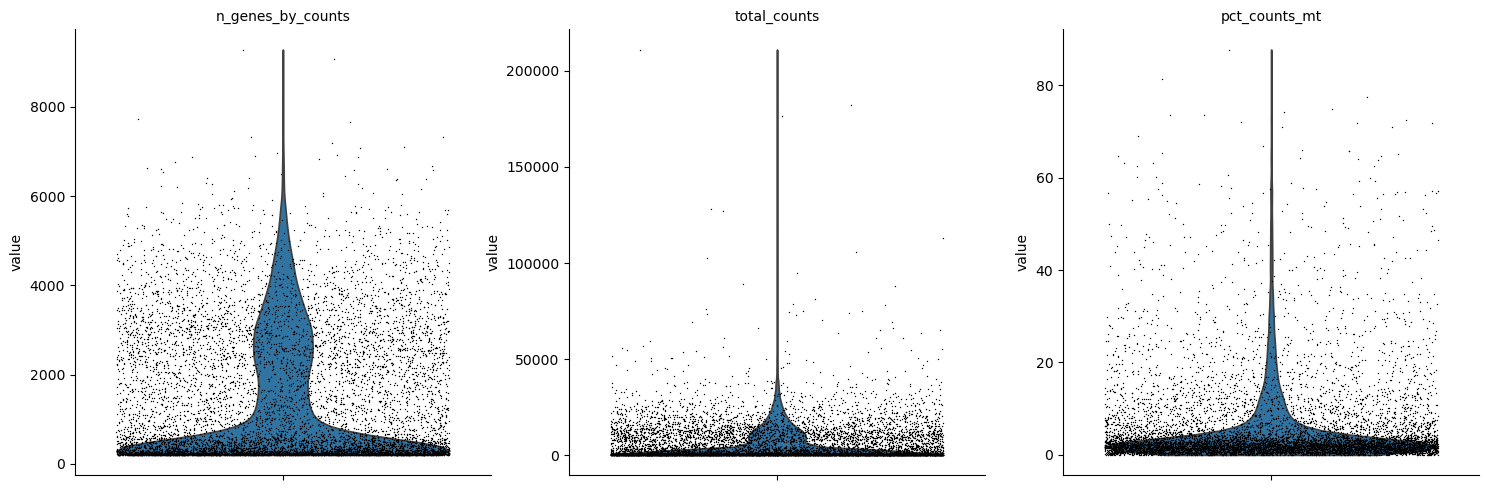

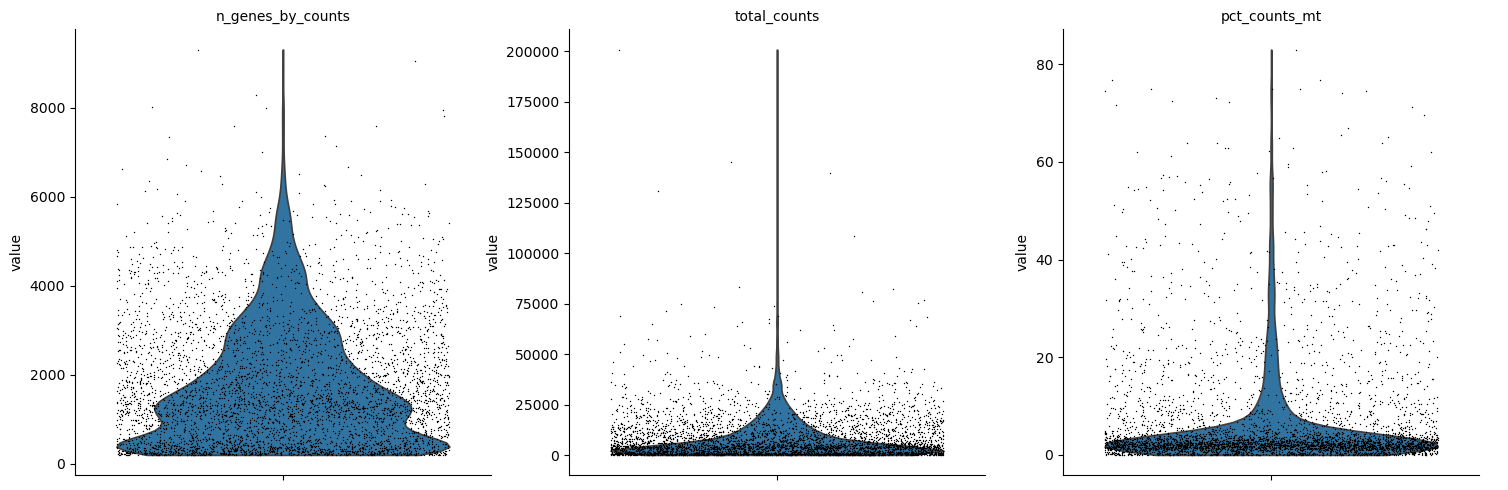

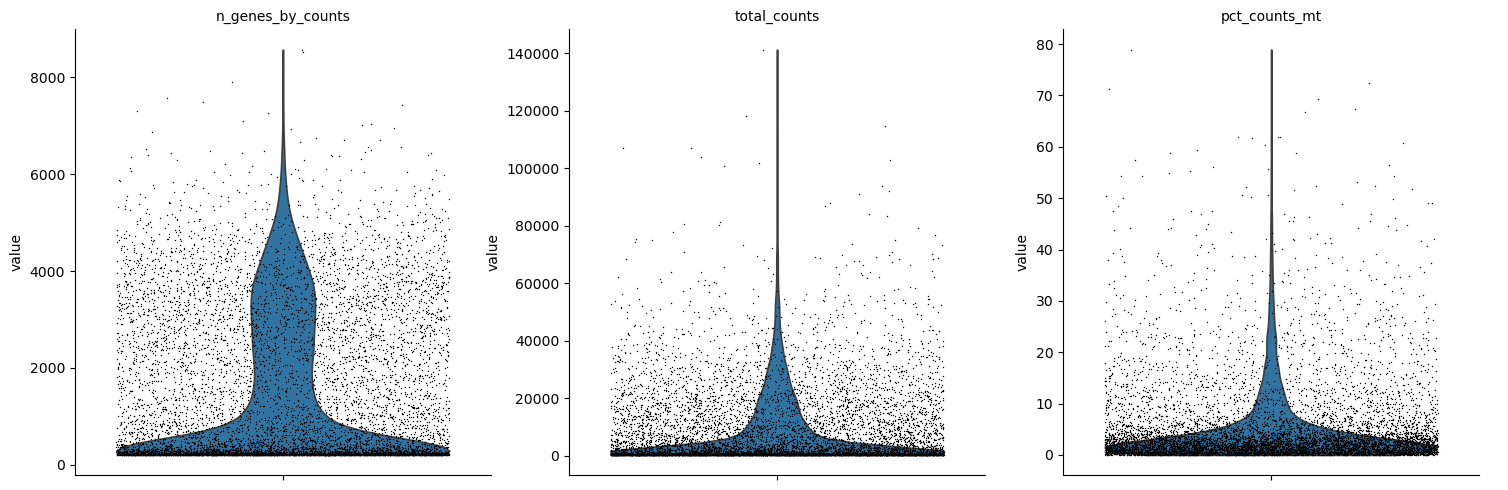

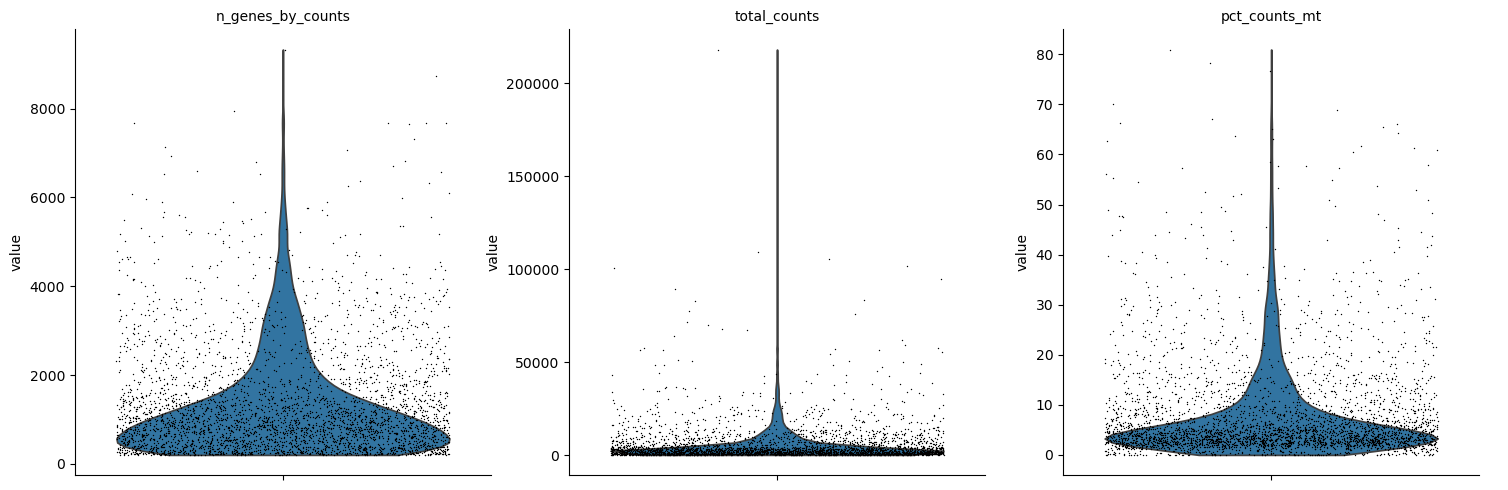

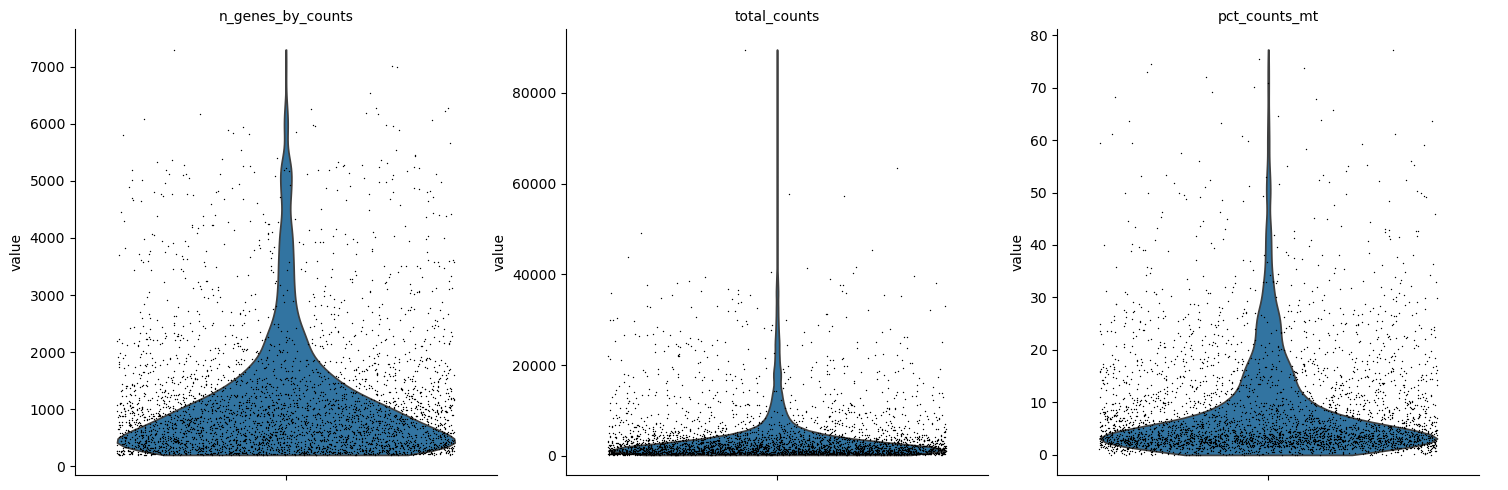

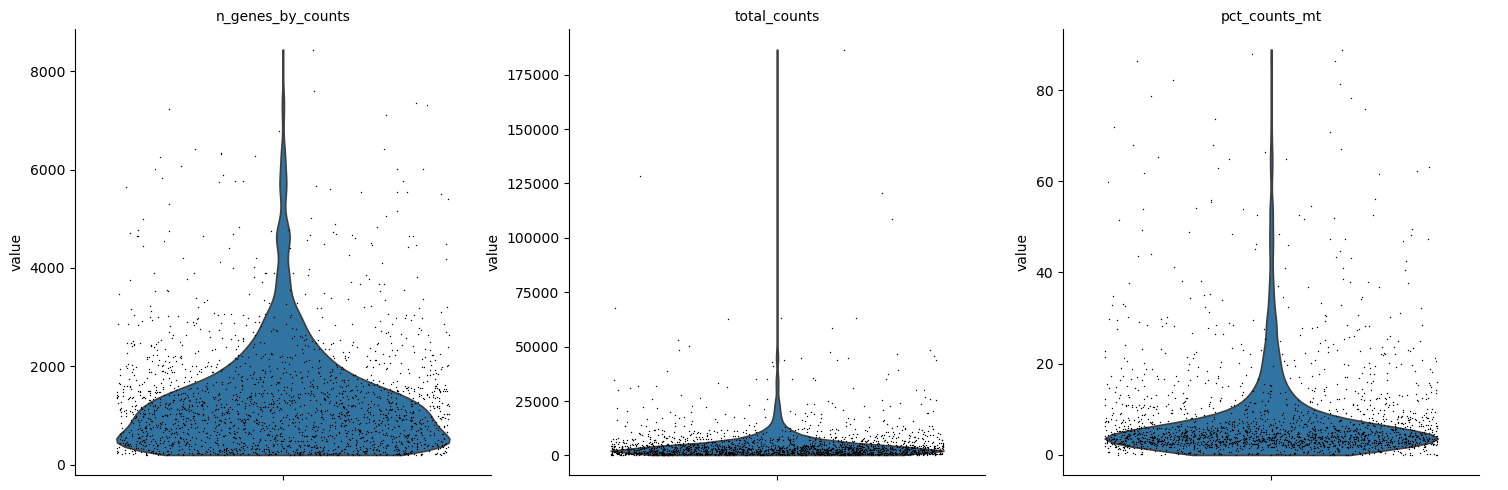

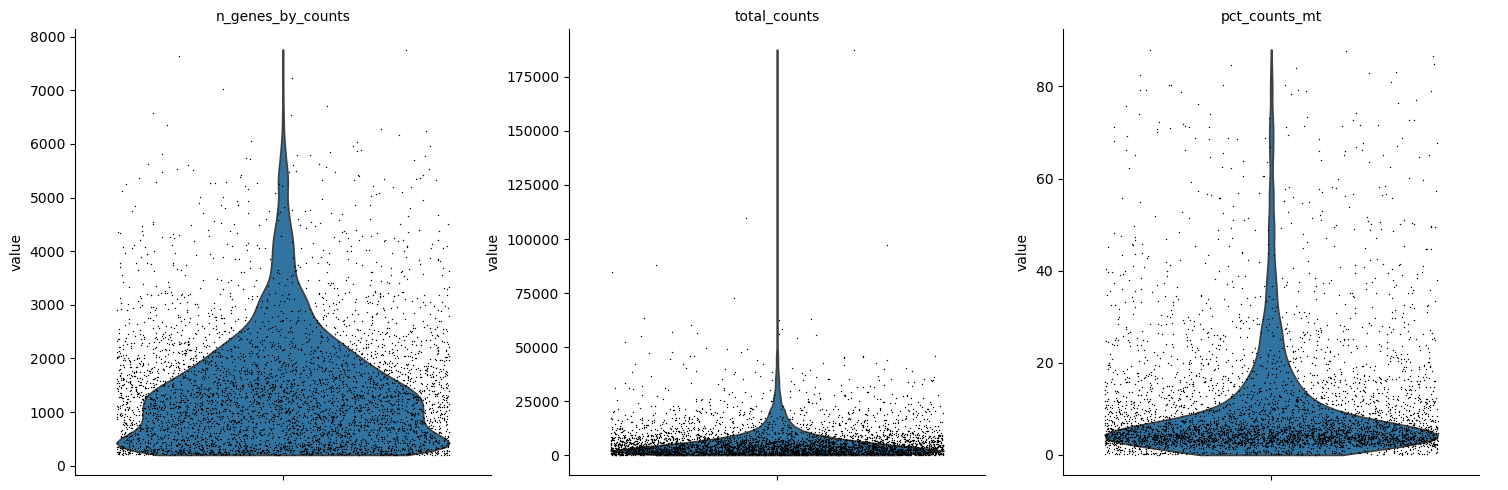

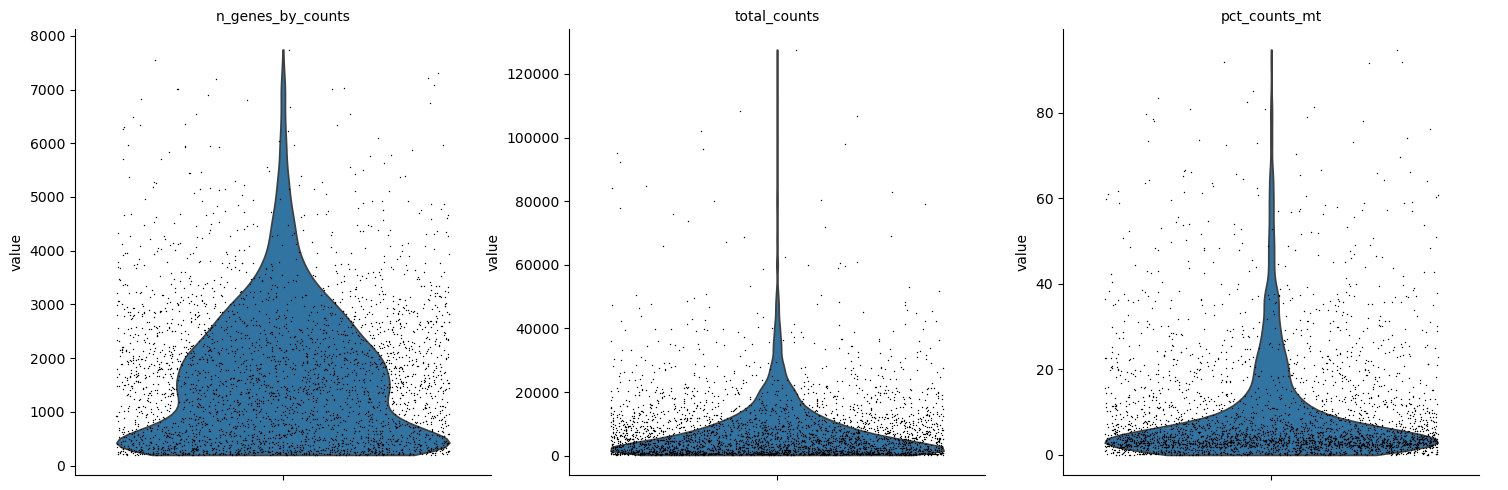

In [7]:
# visualize qc
for dset in prefilt_dsets:
    sc.pl.violin(dset, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True)

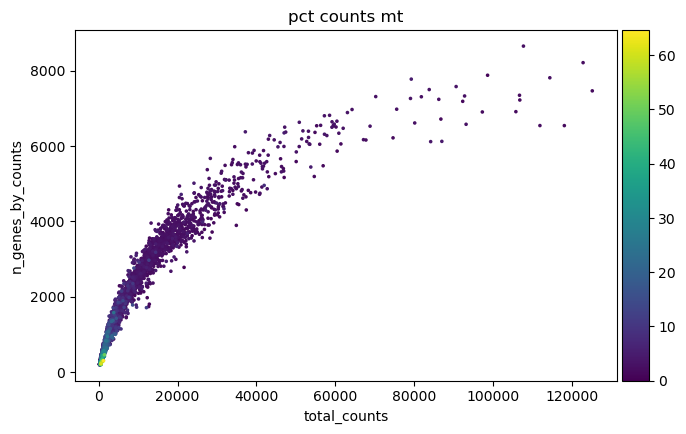

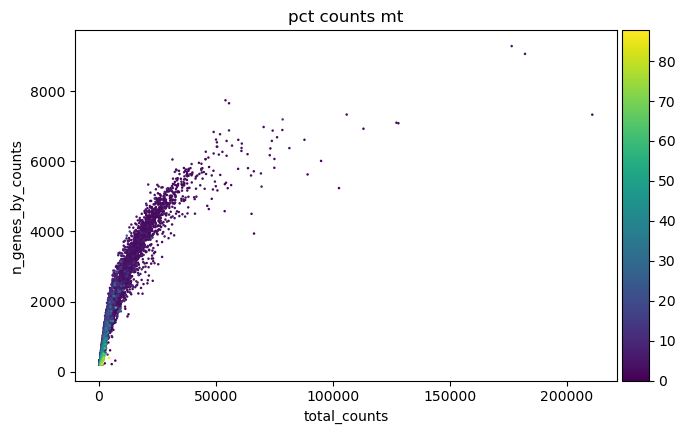

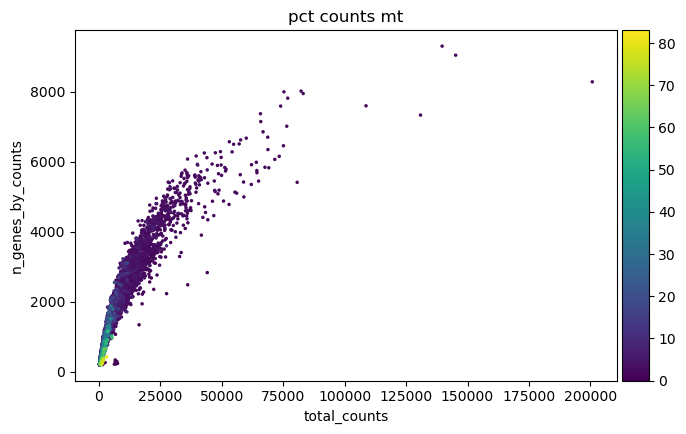

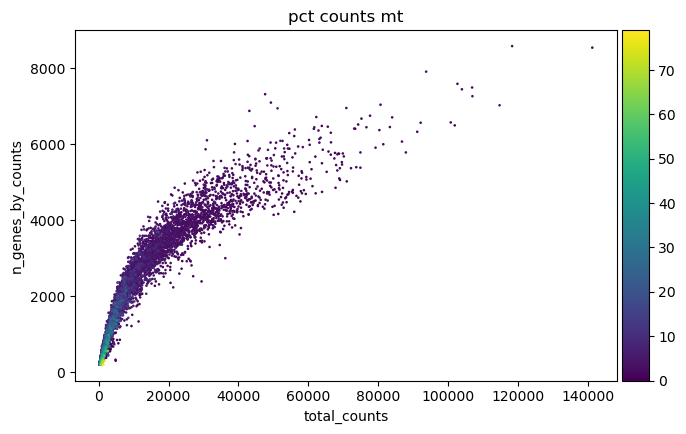

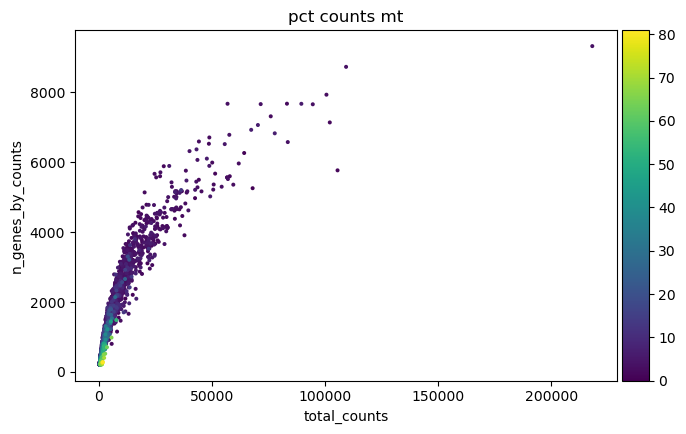

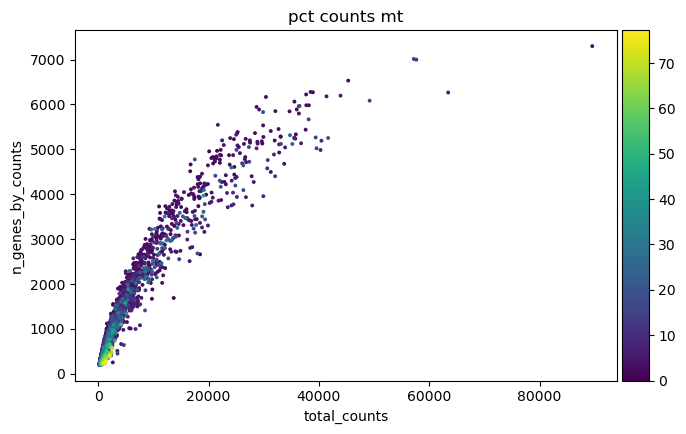

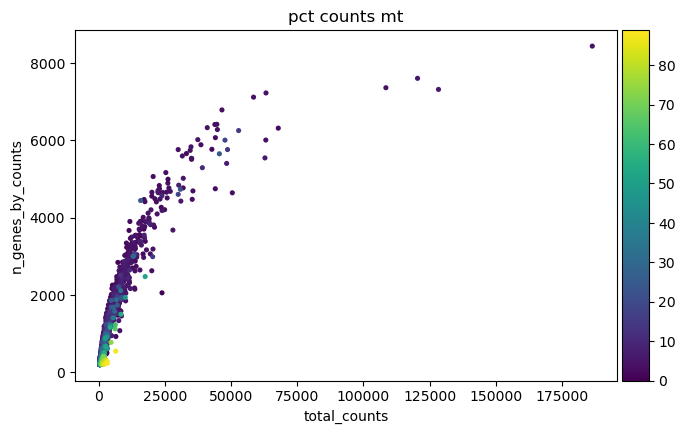

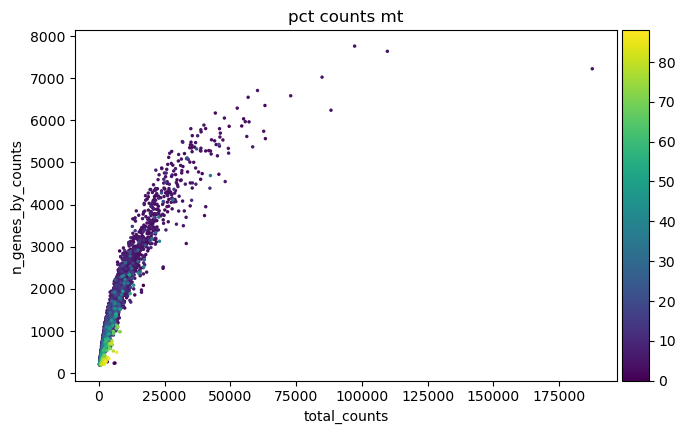

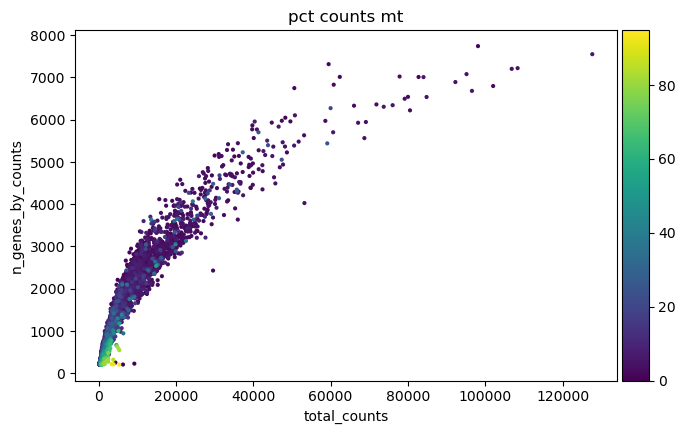

In [8]:
for dset in prefilt_dsets:
    sc.pl.scatter(dset, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Filtering step 1
#### remove genes that are not expressed in any cell, cells that express less than 10 total genes, and cells with >50% mitochondrial genes

In [7]:
for dset in prefilt_dsets:
    sc.pp.filter_cells(dset, min_genes=10)
    sc.pp.filter_genes(dset, min_cells=10)

filtered out 17938 genes that are detected in less than 10 cells
filtered out 16235 genes that are detected in less than 10 cells
filtered out 17155 genes that are detected in less than 10 cells
filtered out 16614 genes that are detected in less than 10 cells
filtered out 17966 genes that are detected in less than 10 cells
filtered out 18022 genes that are detected in less than 10 cells
filtered out 18825 genes that are detected in less than 10 cells
filtered out 17237 genes that are detected in less than 10 cells
filtered out 17670 genes that are detected in less than 10 cells


In [8]:
mf2 = mf2p[mf2p.obs['pct_counts_mt']<50].copy()
mf5 = mf5p[mf5p.obs['pct_counts_mt']<50].copy()
mf6 = mf6p[mf6p.obs['pct_counts_mt']<50].copy()
mf8 = mf8p[mf8p.obs['pct_counts_mt']<50].copy()
mf12 = mf12p[mf12p.obs['pct_counts_mt']<50].copy()

hc1 = hc1p[hc1p.obs['pct_counts_mt']<50].copy()
hc2 = hc2p[hc2p.obs['pct_counts_mt']<50].copy()
hc3 = hc3p[hc3p.obs['pct_counts_mt']<50].copy()
hc4 = hc4p[hc4p.obs['pct_counts_mt']<50].copy()

In [9]:
datasets = [mf2, mf5, mf6, mf8, mf12, hc1, hc2, hc3, hc4]

### Step 2
#### assess potential doublets, consider filtering later

In [13]:
for dset in datasets:
    sc.pp.scrublet(dset)

Running Scrublet
filtered out 2844 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 16.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.7%
    Scrublet finished (0:00:23)
Running Scrublet
filtered out 2996 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.40
Detected 

### Step 3
#### normalization 

In [10]:
for dset in datasets:
    dset.layers['raw_counts'] = dset.X.copy()
    sc.pp.normalize_total(dset, target_sum = 10000)
    sc.pp.log1p(dset)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


### Step 4
#### HVGs, feature selection, PCA, neighbors, umap
after running umap and coloring by doublets, i'm not too worried about there being a significant number of doublets that need to be filtered out

In [11]:
for dset in datasets:
    sc.pp.highly_variable_genes(dset)
    sc.tl.pca(dset)
    sc.pp.neighbors(dset)
    sc.tl.umap(dset)
    sc.tl.tsne(dset)

extracting highly variable genes
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04)
computing UMAP
    finished (0:00:04)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished (0:00:06)
extracting highly variable genes
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:08)
computing UMAP
    finished (0:00:08)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished (0:00:13)
extracting highly variable genes
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:03)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished (0:00:06)
extr

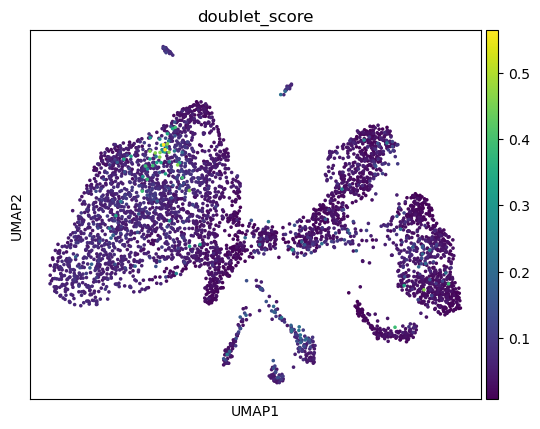

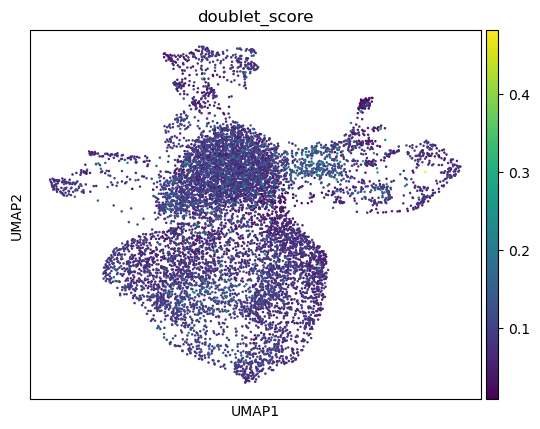

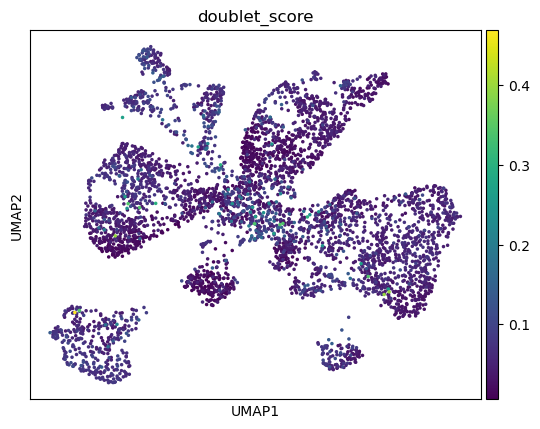

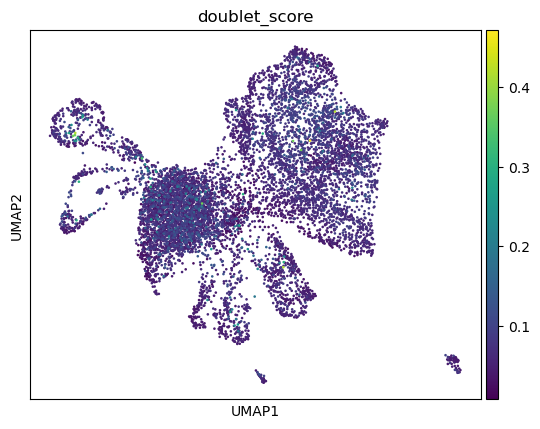

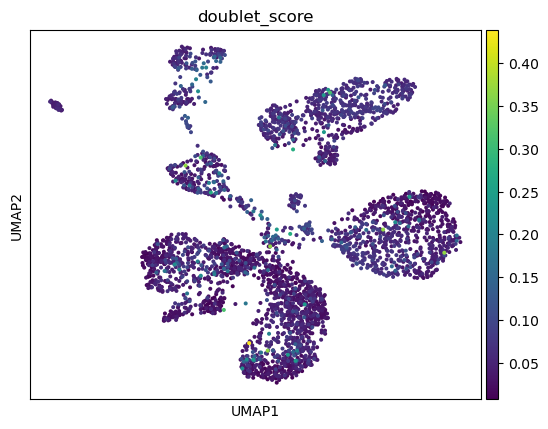

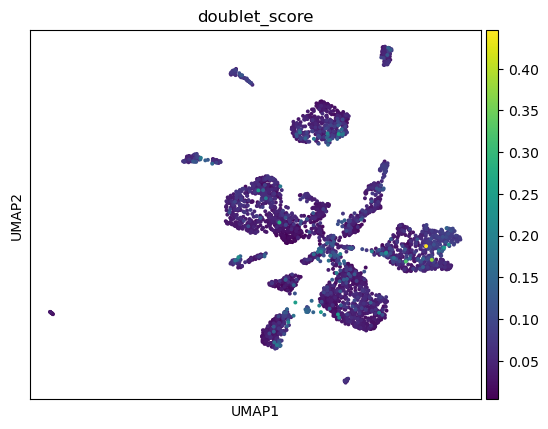

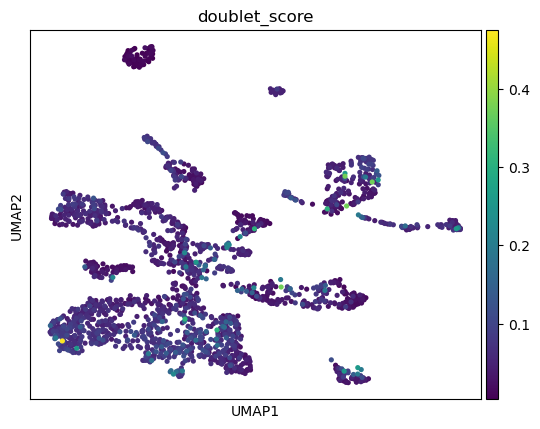

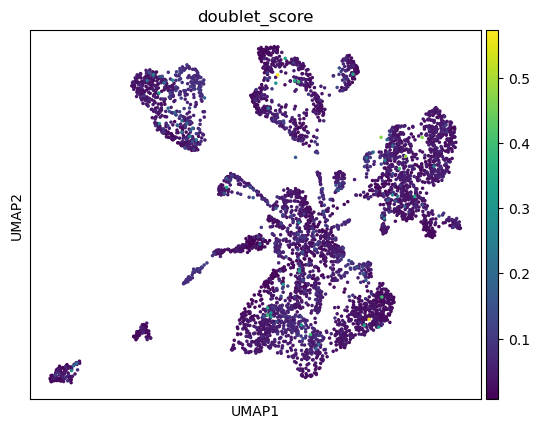

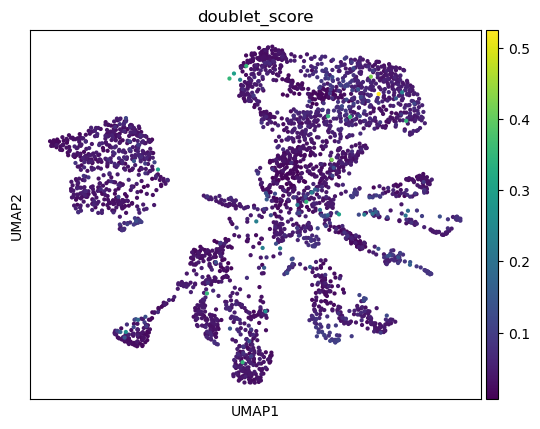

In [16]:
for dset in datasets:
    sc.pl.umap(dset, color='doublet_score')

### Step 5
#### clustering and rank genes groups
Using louvain, leiden, and phenograph for variety
See below for umaps colored by phenograph clusters

In [12]:
for dset in datasets:
  #  sc.tl.leiden(dset)
    sc.tl.louvain(dset)
 #   sc.external.tl.phenograph(dset)
    sc.tl.rank_genes_groups(dset, groupby='louvain')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes
    finished (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes
    finished (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes
    finished (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes
    finished (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes
    finished (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes
    finished (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes


/Users/francescafoglino/miniforge3/envs/ecbm4060/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/francescafoglino/miniforge3/envs/ecbm4060/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/francescafoglino/miniforge3/envs/ecbm4060/lib/python3.12/site-packages/scanp

    finished (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes
    finished (0:00:04)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
ranking genes


/Users/francescafoglino/miniforge3/envs/ecbm4060/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/francescafoglino/miniforge3/envs/ecbm4060/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/francescafoglino/miniforge3/envs/ecbm4060/lib/python3.12/site-packages/scanp

    finished (0:00:02)


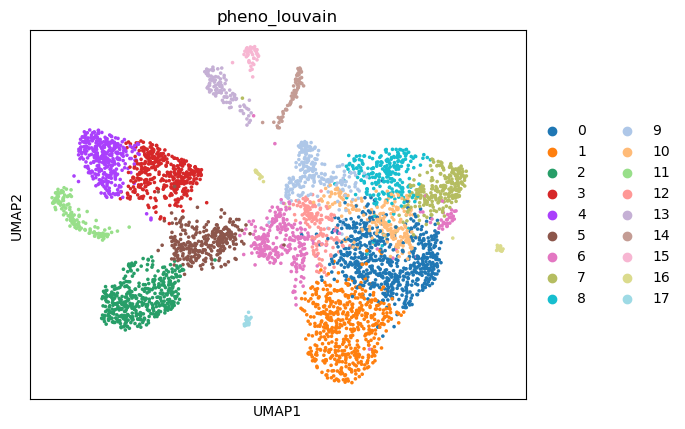

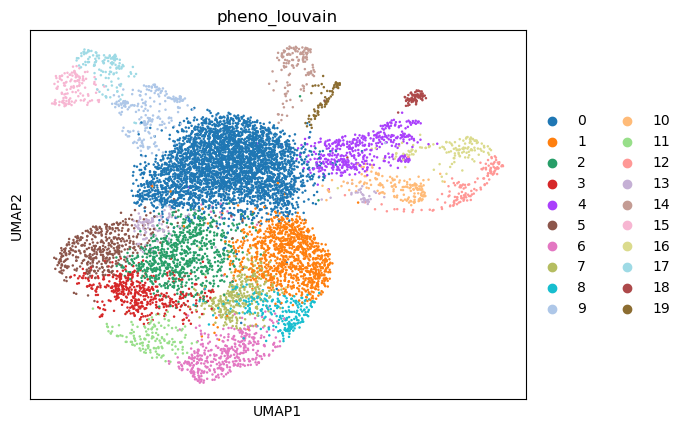

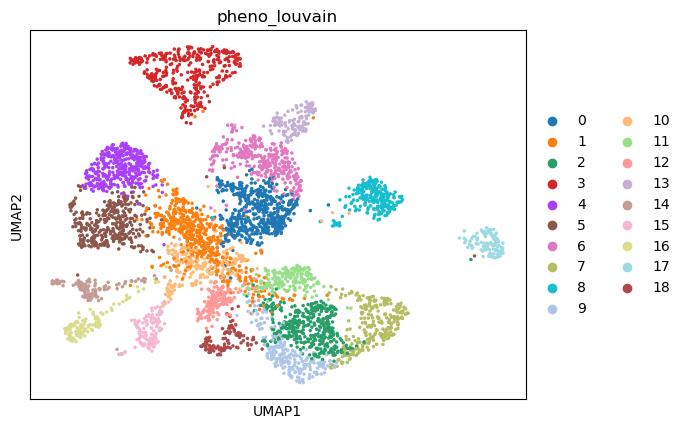

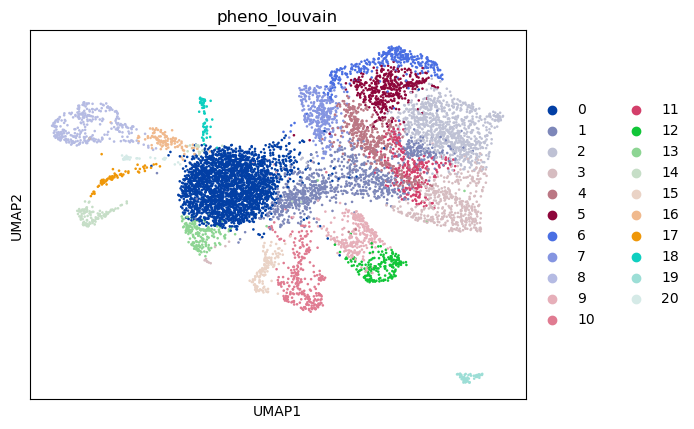

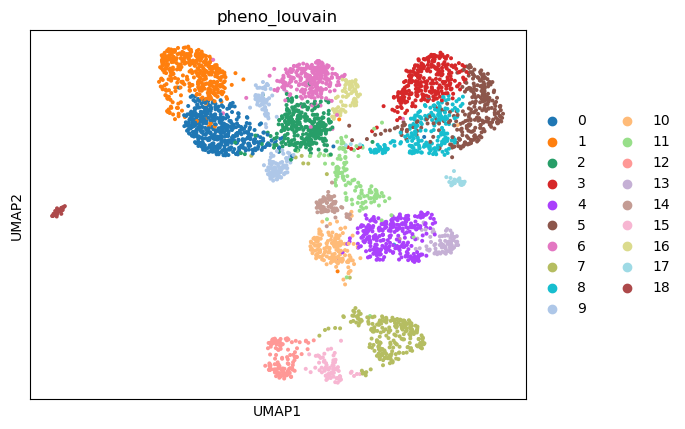

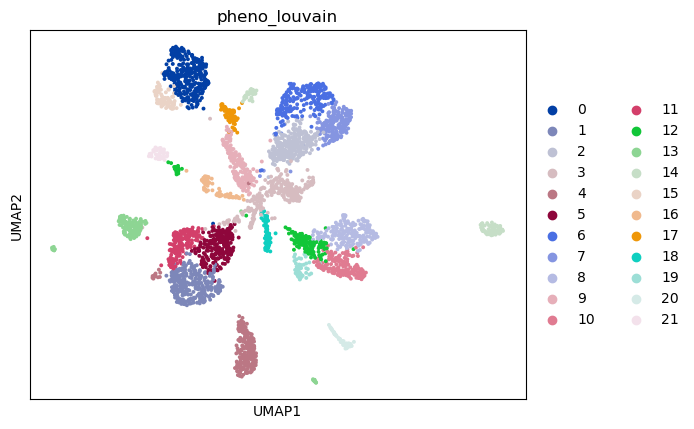

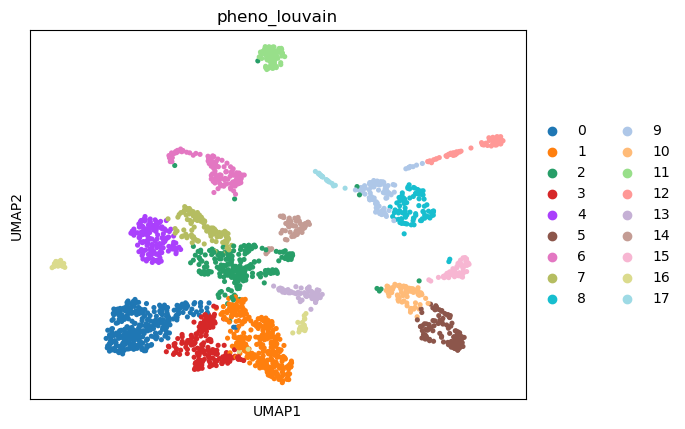

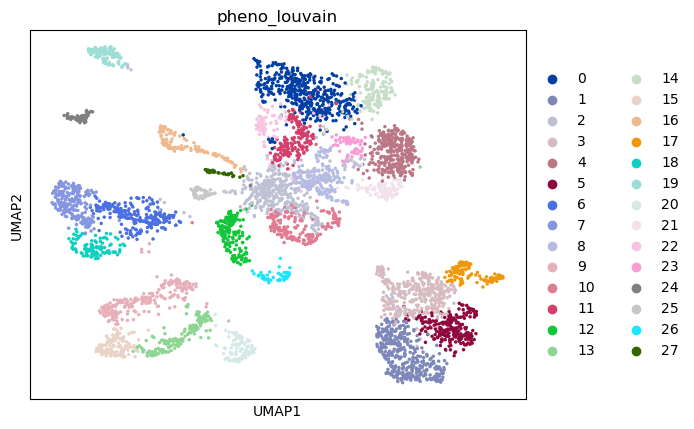

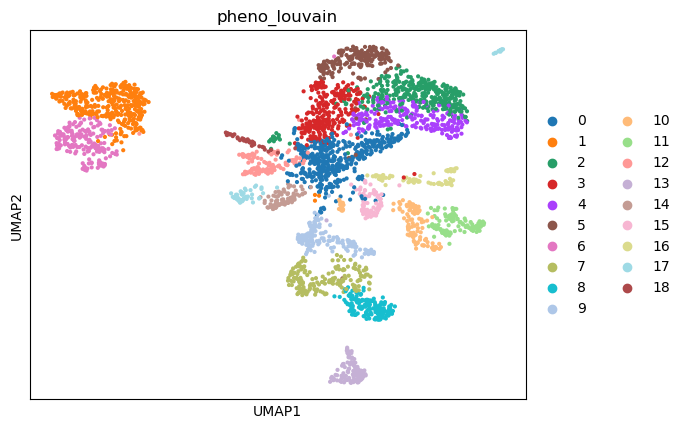

In [185]:
for dset in datasets:
    sc.pl.umap(dset, color='pheno_louvain')

### Step 6
#### Celltypist

In [13]:
model = models.Model.load(model='Immune_All_High.pkl')
for dset in datasets:
    predictions = celltypist.annotate(dset, model=model, majority_voting=True, mode='best match')
    dset = predictions.to_adata()

🔬 Input data has 4434 cells and 15756 genes
🔗 Matching reference genes in the model
🧬 4698 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 8972 cells and 17459 genes
🔗 Matching reference genes in the model
🧬 4982 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 4497 cells and 16539 genes
🔗 Matching reference genes in the model
🧬 5003 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 8395 cells and 17080 genes
🔗 Matching reference genes in the model
🧬 4877 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3458 cells and 15728 genes
🔗 Matching reference genes in the model
🧬 4851 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3617 cells and 15672 genes
🔗 Matching reference genes in the model
🧬 4556 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 2105 cells and 14869 genes
🔗 Matching reference genes in the model
🧬 4485 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 4499 cells and 16457 genes
🔗 Matching reference genes in the model
🧬 4710 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 3071 cells and 16024 genes
🔗 Matching reference genes in the model
🧬 4629 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


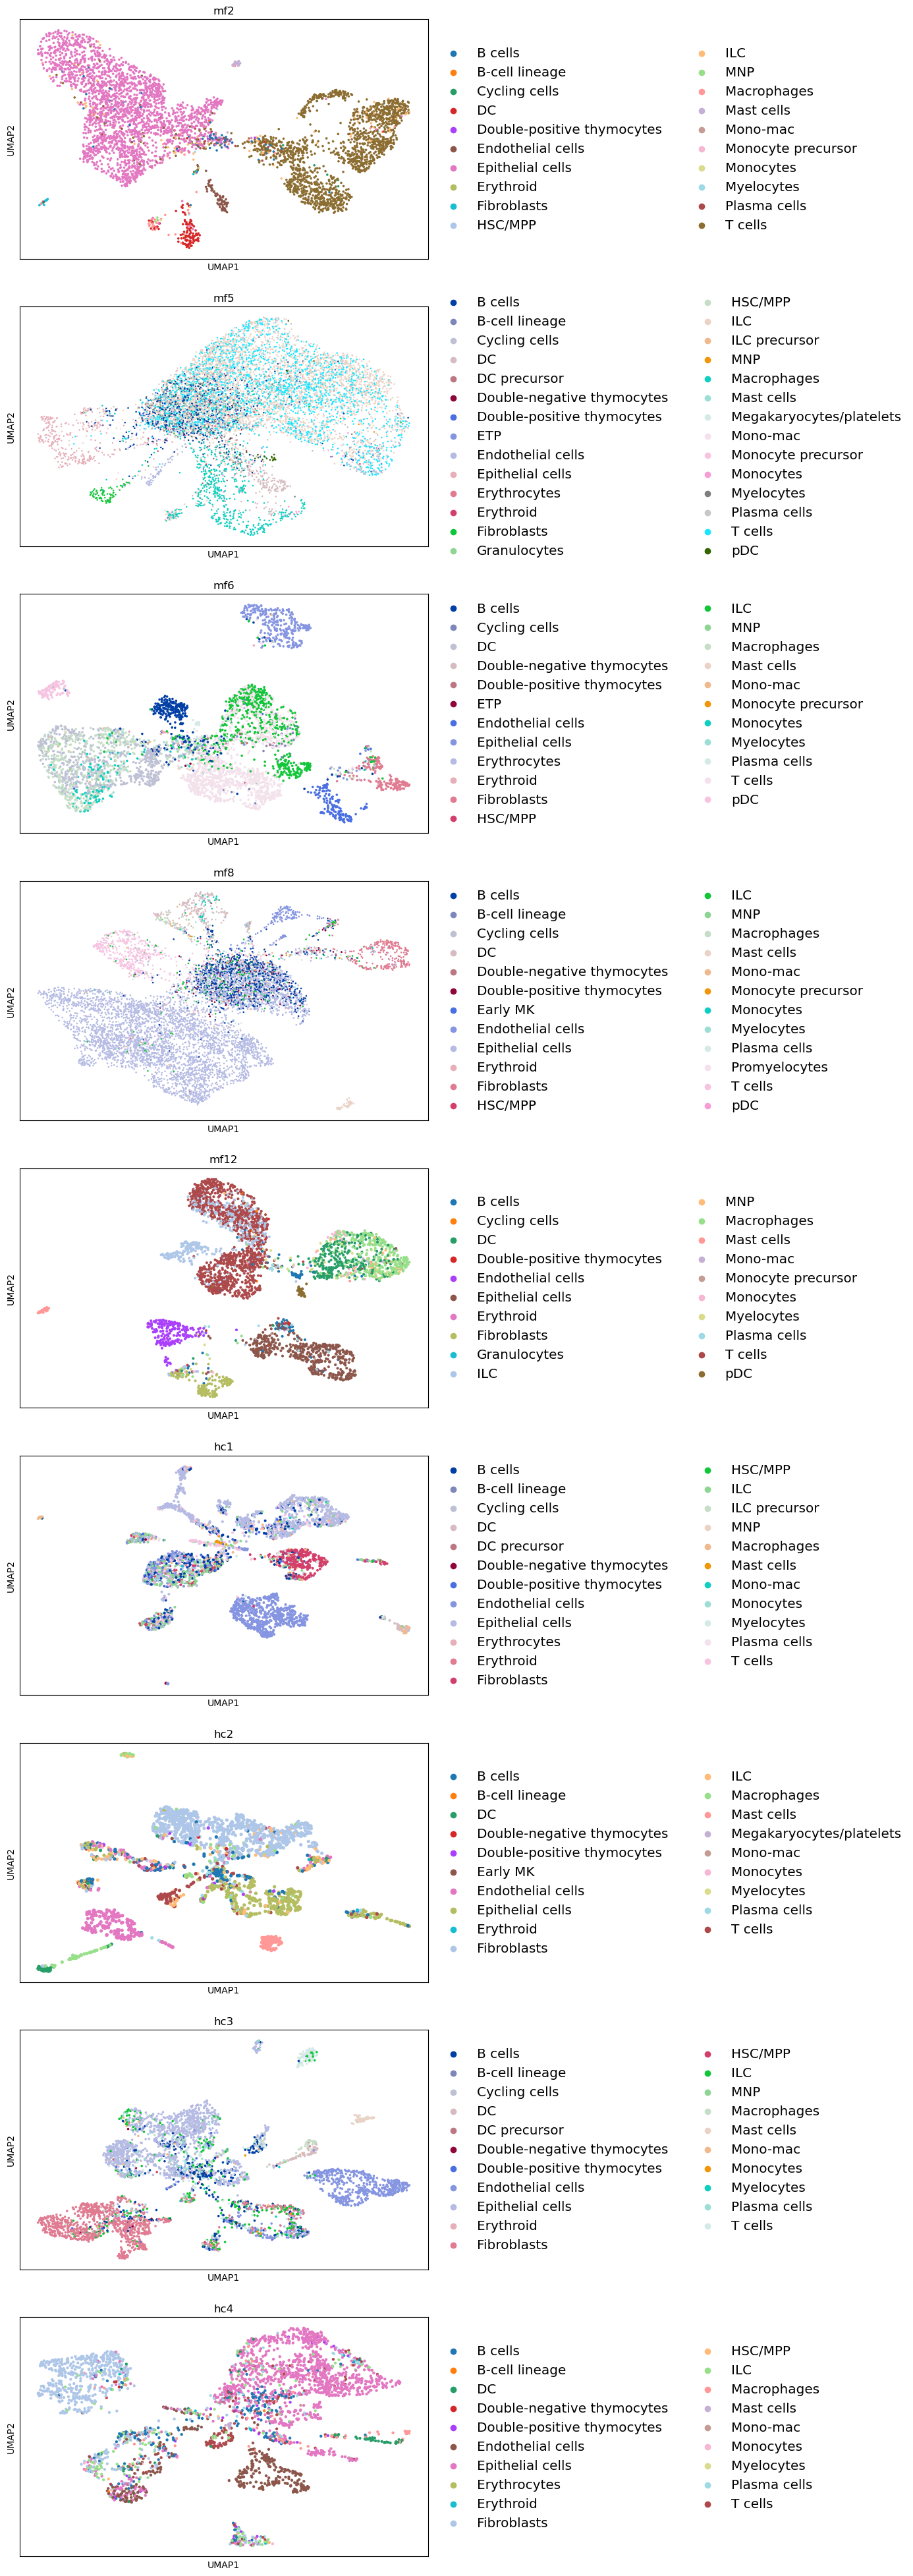

In [40]:
fig, ax = plt.subplots(9,1)
x=0
y=0
i=0
titles = ['mf2', 'mf5', 'mf6', 'mf8', 'mf12', 'hc1', 'hc2', 'hc3', 'hc4']
# for dset in datasets:
#     sc.pl.umap(dset, color='predicted_labels', title=)
fig.set_size_inches(8, 50)
for x in range(9):
        sc.pl.umap(datasets[i], color='predicted_labels',
                  legend_fontsize='x-large',
                   title=titles[i], ax=ax[x], show=False)
        i+=1

### Save data

In [20]:
#datasets = [mf2, mf5, mf6, mf8, mf12, hc1, hc2, hc3, hc4]
dset_name_dict = {
    'mf2':mf2,
    'mf5':mf5,
    'mf6':mf6,
    'mf8':mf8,
    'mf12':mf12,
    'hc1':hc1,
    'hc2':hc2,
    'hc3':hc3,
    'hc4':hc4
}
new_folder_fp = '/Users/francescafoglino/Documents/COLLEGE/Senior/Fall 2024/ECBM 4060 Genomic Info/final_proj/gaydosik_2019_data/gaydosik_2019_filtered/'
from scipy.sparse import csr_matrix
for dset_name in dset_name_dict:
    dset.X = csr_matrix(dset.X)
    dset_name_dict[dset_name].write(filename=new_folder_fp+dset_name+'.h5ad')